In [1]:
import src as gtfs_tool

# Merge

Extracting GTFS zip files and merge the feed into a `TableRepo` object.

**Questions:**
- How to store time data
- What is parent station in stops table - self reference solution

In [ ]:
gtfs_tool.merge_feeds()

# Load graph

Load the merged feed to a `neworkx.MultiDiGraph` object.

In [2]:
graph = gtfs_tool.load_network(gtfs_tool.DATA_DIR / 'tree_unpruned.pickle', prune=False)
graph_unpruned = gtfs_tool.load_network(gtfs_tool.DATA_DIR / 'tree_unpruned.pickle', prune=False)

# Plot nodes

In [3]:
import pandas as pd
from pathlib import Path
from matplotlib import pyplot as plt
from tqdm import tqdm
import networkx as nx
from dotenv import load_dotenv
from parquetranger import TableRepo
from src.naming import DATA_DIR, HOUR
from src.meta import Stops, StopTimes
import numpy as np
import geopandas as gpd
from shapely.geometry import LineString

In [4]:
hungary_fp = Path("hungary.geojson")
hungary = gpd.read_file(filename=hungary_fp)

In [5]:
stops_trepo = TableRepo(root_path=DATA_DIR / "stops")
stop_times_trepo = TableRepo(root_path=DATA_DIR / "stop_times")

In [6]:
stops_df = (
    stops_trepo.get_full_df()
    .pipe(
        lambda _df: gpd.GeoDataFrame(
            _df, geometry=gpd.points_from_xy(_df[Stops.stop_lon], _df[Stops.stop_lat])
        )
    )
    .assign(publisher=lambda _df: _df.index.str.split("_").str[-1])
)
stop_times_df = stop_times_trepo.get_full_df()

In [7]:
PUB_COLOR_MAP = {
    "BKV": "purple",
    "MÁV": "darkblue",
    "VOLÁN": "orange",
}

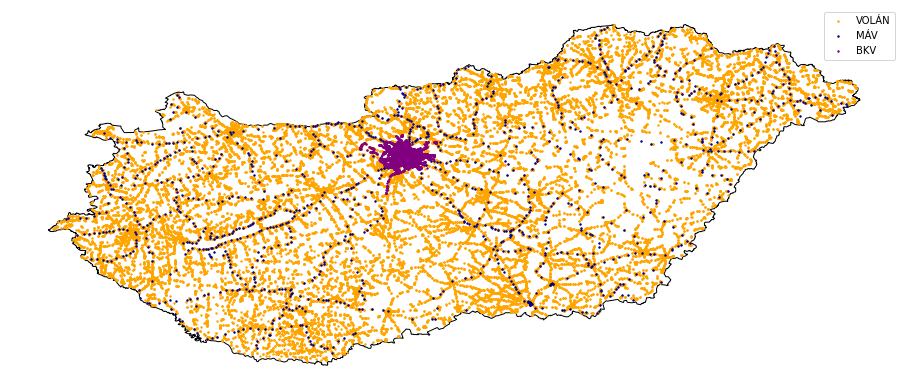

In [8]:
fig, ax = plt.subplots(figsize=(16, 8))
hungary.plot(ax=ax, color="white", edgecolor="black")
for publisher, pub_data in stops_df.sort_values("publisher", ascending=False).groupby(
    by="publisher", sort=False
):
    pub_data.plot(ax=ax, color=PUB_COLOR_MAP[publisher], markersize=2, label=publisher)
ax.legend()
plt.axis("off")
plt.savefig("outputs/figures/all_nodes.png")
plt.show()

# Query distance

In [9]:
from fuzzysearch import find_near_matches
from collections.abc import Iterable

In [10]:
def stop_search(pattern: str, text: str, fuzzy: bool = True)->bool:
    if fuzzy:
        return (
            len(
                find_near_matches(
                    pattern,
                    text,
                    max_substitutions=0,
                    max_insertions=0,
                    max_deletions=0,
                    max_l_dist=1,
                )
            )
            != 0
        )
    else:
        return pattern == text


def _get_repr_node(pattern: str, stops: pd.DataFrame, fuzzy: bool = False, add_query: bool = False) -> pd.DataFrame:
    df = stops[
        lambda _df: (
            _df[Stops.stop_name]
            .str.split(r"[^\w\s]", regex=True)
            .str[0]
            .apply(lambda x: stop_search(pattern.title(), x, fuzzy=fuzzy))
        )
    ]
    if not df.empty:
        df =  df.loc[lambda _df: [_df["out_degree"].idxmax()], :]
        if add_query:
            df = df.assign(query=pattern)
        return df


def search_representative_node(
    pattern, stops: pd.DataFrame, fuzzy: bool = False, add_query: bool = False
) -> pd.DataFrame:
    if isinstance(pattern, Iterable) and not isinstance(pattern, str):
        return pd.concat(
            [
                _get_repr_node(stops=stops, pattern=p, fuzzy=fuzzy, add_query=add_query)
                for p in tqdm(pattern)
            ],
            axis=0,
        )
    else:
        return _get_repr_node(stops=stops, pattern=pattern, fuzzy=fuzzy, add_query=add_query)

In [11]:
stops_df = stops_df.assign(
    out_degree=pd.DataFrame(
        graph_unpruned.out_degree(), columns=[Stops.stop_id, "out_degree"]
    ).set_index(Stops.stop_id)["out_degree"]
)

In [12]:
DEPARTURE_CITIES = [
    "Galgagyörk",
    "Piricse",
    "Nyíradony",
    "Nagycsécs",
    "Alsózsolca",
    "Tatárszentgyörgy",
    "Tiszalök",
    "Kisléta",
    "Ipolytarnóc",
    "Erdőkertes",
    "Tura",
    "Kisvárda",
    "Debrecen",
]

In [13]:
departure_stops = search_representative_node(
    DEPARTURE_CITIES, stops_df, fuzzy=False, add_query=True
).set_crs("EPSG:4326")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  3.55it/s]


In [14]:
COUNTY_DIR = Path(
    "C:/Users/PSebi/OneDrive/data-storage/geo-data-hungary/GeoJSON/l30-county"
)

hungary_counties = gpd.GeoDataFrame(
    pd.concat([gpd.read_file(fp) for fp in COUNTY_DIR.glob("*.geojson")]),
    geometry="geometry",
).set_index("name")

In [15]:
ARRIVAL_COUNTIES = [
    "Borsod-Abaúj-Zemplén megye",
    "Szabolcs-Szatmár-Bereg megye",
    "Hajdú-Bihar megye",
    "Heves megye",
    "Jász-Nagykun-Szolnok megye",
    "Bács-Kiskun megye",
    "Nógrád megye",
    "Pest megye",
    "Békés megye",
    "Csongrád megye",
]

In [16]:
arrival_stops_all = stops_df.set_crs("EPSG:4326").sjoin(
    hungary_counties.loc[ARRIVAL_COUNTIES, :], how="inner"
)

In [17]:
geodata_fp = Path(
    "C:/Users/PSebi/OneDrive/data-storage/teruleti_szamjelrendszer_struktura_elemei_2021_megnevezesekkel.xlsx"
)

arrival_cities = pd.read_excel(geodata_fp)[
    lambda _df: (
        (_df["Jogállás 2005"] != 90)
        & (
            _df["Területi jelzőszámból képzett megyekód"].isin(
                hungary_counties.loc[ARRIVAL_COUNTIES, "ksh"].astype(int)
            )
        )
    )
]

In [ ]:
arrival_stops = search_representative_node(
    arrival_cities["Név"], stops_df, fuzzy=False, add_query=True
).set_crs("EPSG:4326")

arrival_stops.to_parquet('arrival_stops.parquet')

In [18]:
arrival_stops = pd.read_parquet('arrival_stops.parquet')

In [56]:
arrival_stops = arrival_stops.pipe(
    lambda _df: gpd.GeoDataFrame(
        _df,
        geometry=gpd.points_from_xy(
            arrival_stops[Stops.stop_lon], arrival_stops[Stops.stop_lat]
        ),
    )
)

In [19]:
set(arrival_cities['Név']).difference(arrival_stops['query'])

{'Buj', 'Hernádbűd', 'Iliny', 'Kótaj', 'Remeteszőlős', 'Timár', 'Tornakápolna'}

In [20]:
city_dists = (
    departure_stops.reset_index()
    .join(arrival_stops.reset_index(), how="cross", lsuffix="_start", rsuffix="_stop")[
        [Stops.stop_id + "_start", Stops.stop_id + "_stop"]
    ]
    .assign(
        distance = lambda _df: gtfs_tool.get_travel_time(
            graph=graph,
            stop_pairs=_df.values,
            pbar=True,
            batch_size=100,
            verbose=True,
        )
    )
)

city_dists.to_parquet('city_dists.parquet')

In [69]:
city_dists_all = (
    city_dists.merge(
        departure_stops.rename(lambda x: x + "_start", axis=1),
        left_on=Stops.stop_id + "_start",
        right_index=True,
    ).merge(
        arrival_stops.rename(lambda x: x + "_stop", axis=1),
        left_on=Stops.stop_id + "_stop",
        right_index=True,
    )
).set_index([Stops.stop_id + "_start", Stops.stop_id + "_stop"])

In [60]:
from src.network import _get_node_recs, _get_edge_recs

In [84]:
city_graph = nx.MultiDiGraph()

city_graph.add_nodes_from(
    _get_node_recs(arrival_stops)
)

city_graph.add_edges_from(_get_edge_recs(city_dists_all))
pass

In [93]:
import contextily as cx

In [105]:
positions = dict(zip(arrival_stops.index, arrival_stops[[Stops.stop_lon, Stops.stop_lat]].values))

In [244]:
city_dists_all.reset_index().drop(
    columns=[
        "stop_id_start",
        "stop_id_stop",
        "geometry_start",
        "geometry_stop",
        "out_degree_start",
        "out_degree_stop",
        "publisher_start",
        "publisher_stop",
    ]
).to_csv('distances.csv')

(18.51196675, 23.06953625, 45.81423515, 48.69400985)

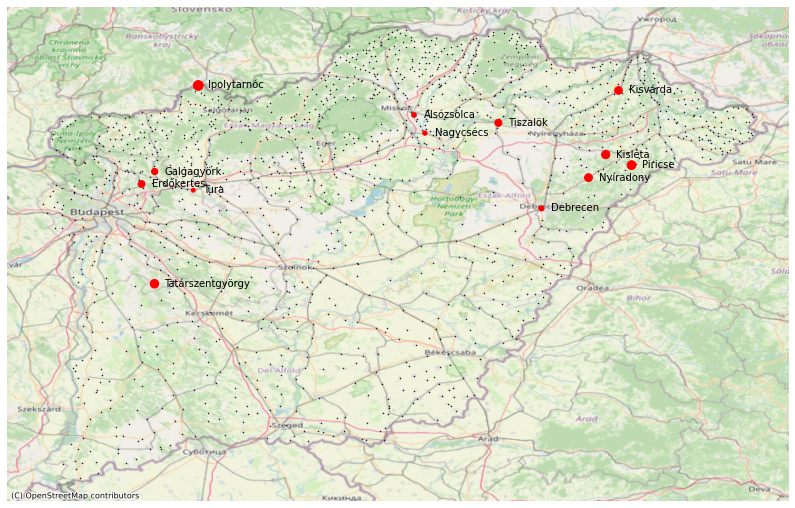

In [237]:
fig, ax = plt.subplots(figsize=(14, 14))
arrival_stops.plot(ax=ax, marker=".", markersize=1, color="black")
departure_stops.plot(
    ax=ax,
    marker=".",
    markersize=(
        (
            departure_stops.index.map(
                city_dists.groupby(Stops.stop_id + "_start")["distance"]
                .mean()
                .pipe(lambda x: (x - x.mean()) / x.std())
            )
        )
        * 100
        + 200
    ),
    color="red",
)

for stop in departure_stops.index:
    ax.annotate(
        text=departure_stops.loc[stop, "query"],
        xy=departure_stops.loc[stop, [Stops.stop_lon, Stops.stop_lat]],
        xytext = (10, -3),
        textcoords = 'offset points'
    )

cx.add_basemap(ax=ax, crs="EPSG:4326", source=cx.providers.OpenStreetMap.Mapnik)
ax.axis("off")

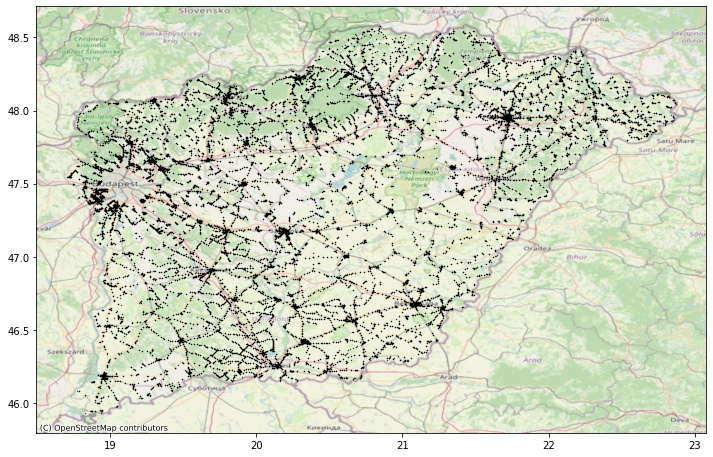

In [140]:
fig, ax = plt.subplots(figsize=(12, 12))

# hungary.plot(ax = ax, edgecolor="black", facecolor=None)
# hungary_counties.loc[ARRIVAL_COUNTIES, :].plot(
#     ax=ax, edgecolor="black", facecolor="white"
# )
arrival_stops_all.plot(ax=ax, marker=".", markersize=0.5, color="black")
# departure_stops.plot(ax=ax, markersize=10, color="green")
cx.add_basemap(ax=ax, crs="EPSG:4326", source=cx.providers.OpenStreetMap.Mapnik)

In [40]:
start = stops_df[lambda _df: _df["stop_name"] == "Pomáz"].index[0]
stop = stops_df[lambda _df: _df["stop_name"] == "Martonvásár"].index[0]

shortest_path = nx.dijkstra_path(graph, start, stop, weight="distance")
nx.dijkstra_path_length(graph, start, stop, weight="distance") / HOUR

0.9631649535367283

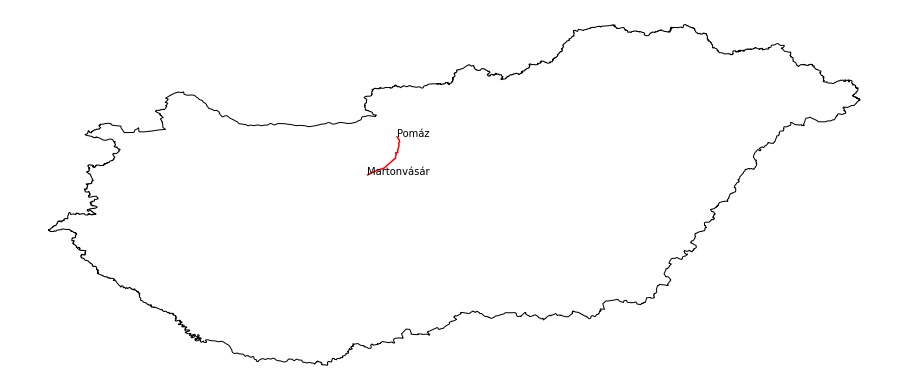

In [41]:
spath = gpd.GeoSeries(
    LineString(
        [
            (graph.nodes[stop]["stop_lon"], graph.nodes[stop]["stop_lat"])
            for stop in shortest_path
        ]
    )
)

fig, ax = plt.subplots(figsize=(16, 16))
hungary.plot(ax=ax, color="white", edgecolor="black")
spath.plot(ax=ax, color="red", markersize=1)

for stop in [shortest_path[0], shortest_path[-1]]:
    ax.annotate(
        text=stops_df.loc[stop, Stops.stop_name],
        xy=stops_df.loc[stop, [Stops.stop_lon, Stops.stop_lat]],
        xycoords="data",
    )

plt.axis("off")
plt.savefig("outputs/figures/path_example.png")
plt.show()